In [1]:
# Import libraries
import numpy as np
import pandas as pd
import zipfile
import os
import tqdm
import pathlib
import tqdm
import time
import requests
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error

2022-08-01 10:42:15.276549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-01 10:42:15.276582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# !conda install python-graphviz --yes

In [3]:
# !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip
# !unzip ukiyoe2photo.zip

In [4]:
def load_rescale(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image,channels=3)
    image = tf.keras.layers.Rescaling(1./127.5, offset=-1)(image)
    return image

In [5]:
BATCH_SIZE = 4
train_dataset_u = tf.data.Dataset.list_files('ukiyoe2photo/trainA/*.jpg') \
                                                .map(load_rescale,num_parallel_calls=tf.data.AUTOTUNE) \
                                                .shuffle(100) \
                                                .batch(BATCH_SIZE)
train_dataset_o = tf.data.Dataset.list_files('ukiyoe2photo/trainB/*.jpg') \
                                                .map(load_rescale,num_parallel_calls=tf.data.AUTOTUNE) \
                                                .shuffle(100) \
                                                .batch(BATCH_SIZE)

2022-08-01 10:42:23.722000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-01 10:42:23.722040: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-01 10:42:23.722064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-08-01 10:42:23.726393: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Having a quick look at a few sample 
# fig,ax = plt.subplots(1,5,figsize=(20,3))
# fig.suptitle('Sample Data for F',fontsize=22)
# i = 0
# for img in train_dataset_u.take(5):
#     ax[i].imshow(img[0])
#     i += 1
# plt.show()

In [7]:
# Having a quick look at a few sample 
# fig,ax = plt.subplots(1,5,figsize=(20,3))
# fig.suptitle('Sample Data for F',fontsize=22)
# i = 0
# for img in train_dataset_o.take(5):
#     noise = tf.random.normal(shape=(256,256,1),mean=2,stddev=1.5)
#     concat_image_noise = layers.Concatenate(axis=-1)([img[0],noise])
#     ax[i].imshow(concat_image_noise[:,:,:4])
#     i += 1
# plt.show()

The 70 × 70 discriminator architecture is:
C64-C128-C256-C512

After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.
As an exception to the above notation, BatchNorm is not
applied to the first C64 layer. All ReLUs are leaky, with
slope 0.2.

#### All networks were trained from scratch, and trained with learning rate of 0.0002 
#### for the first 100 epochs and linearly decaying rate to zero for the next 100 epochs. 
#### Weights were initialized from a Gaussian distribution with mean 0 and standard deviation 0.02.

In [8]:
# Your code here
d_loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
initializer= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_discriminator(input_dim,leaky_alpha=0.2):
    inputs= layers.Input(input_dim)    
    x=layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(inputs)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    x=layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(alpha=leaky_alpha)(x)
    
    output=layers.Conv2D(1,(4,4),strides=(1,1),activation='sigmoid',padding='same')(x)


    model_disc=Model(inputs,output)
    model_disc.compile(loss=d_loss,optimizer=d_optimizer,metrics=['accuracy'])
    return model_disc


In [9]:
# build_discriminator((256,256,3),leaky_alpha=0.2).summary()

In [10]:
# p=0
# k=4
# s=2
# o=1
# for s in [1,1,2,2,2]:#[256,128,64,32,16]:
#     n=(o-1)*s + k -2*p
#     o=n
#     print(i,n)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

### 1) Let c7s1-k denote a 7 × 7 Convolution-BatchNorm-ReLU layer with k filters and stride 1. 

### 2) dk denotes a 3 × 3 Convolution-BatchNorm-Dropout-ReLU layer with k filters, and stride 2. 

### 3) Reflection padding was used to reduce artifacts. 

### 4) Rk denotes a residual block that contains two 3×3 convolutional layers with the same number of filters on both layer.

### 5) uk denotes a 3 × 3 fractional-strided-Convolution-BatchNorm-Dropout-ReLU layer with k filters, and stride 1/2 .

The network with 9 blocks consists of:
### c7s1-32, d64, d128, R128, R128, R128, R128, R128, R128, R128, R128, R128, u64, u32, c7s1-3

In [11]:
def cyclic_loss(x,y):
    # return mean_absolute_error(F(G(x)),x) + mean_absolute_error(G(F(y)),y)   
    return tf.reduce_mean(F(G(x))-x) + tf.reduce_mean(G(F(y))-y)

In [12]:
# g_loss= # new loss
g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002)
initializer= tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_generator(latent_dim=(256,256,1)):
    input_image = layers.Input(shape=(256,256,3))
    noise = tf.random.normal(shape=(BATCH_SIZE,256,256,1),mean=2,stddev=1.5)

    concat_image_noise = layers.Concatenate(axis=-1)([input_image,noise])
    
    x=layers.Conv2D(32,(7,7),strides=1,padding='same',kernel_initializer=initializer)(input_image)#(concat_image_noise)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(64,(3,3),strides=2,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2D(128,(3,3),strides=2,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x_residue=layers.ReLU()(x)

    #Residual Block
    for i in range(9):
        x=layers.Conv2D(128,(3,3),strides=1,padding='same',kernel_initializer=initializer)(x_residue)
        x=layers.BatchNormalization()(x)
        x=layers.ReLU()(x)
        x=layers.Conv2D(128,(3,3),strides=1,padding='same',kernel_initializer=initializer)(x)
        x=layers.BatchNormalization()(x)
        x=layers.ReLU()(x)
        x_residue=layers.Concatenate()([x,x_residue])
        
    #Fractional strided layers
    x=layers.Conv2DTranspose(64,(3,3),strides=2,dilation_rate=1,padding='same',kernel_initializer=initializer)(x_residue)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2DTranspose(32,(3,3),strides=2,dilation_rate=1,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.ReLU()(x)

    x=layers.Conv2DTranspose(3,(7,7),strides=1,padding='same',kernel_initializer=initializer)(x)
    x=layers.BatchNormalization()(x)
    x=tf.keras.activations.tanh(x)
    
    model_gen=Model(input_image ,x)
    model_gen.compile(loss='bce',optimizer=g_optimizer,metrics=['accuracy'])
    return model_gen

In [13]:
# model_gen = build_generator(latent_dim=(256,256,1))
# plot_model(model_gen)
# model_gen.summary()

We keep an image buffer that stores 50 previously generated images.

In [14]:
def adverserial_loss(Dy,DGx):
    disc_loss = tf.keras.metrics.mean_squared_error(Dy,tf.cast(tf.ones_like(Dy),tf.float32))
    gen_loss = tf.keras.metrics.mean_squared_error(DGx,tf.cast(tf.ones_like(DGx),tf.float32) )
    total_loss = disc_loss + gen_loss
    return total_loss

def gen_loss(DGx):
  return tf.keras.metrics.mean_squared_error(DGx,tf.cast(tf.ones_like(DGx),tf.float32) )

In [15]:
Dx = build_discriminator((256,256,3),leaky_alpha=0.2)
Dy = build_discriminator((256,256,3),leaky_alpha=0.2)
G = build_generator(latent_dim=(256,256,1))
F = build_generator(latent_dim=(256,256,1))

In [16]:
# # Traininig 
# Real_buffer_x = []
# Real_buffer_y = []
# Fake_buffer_x = []
# Fake_buffer_y = []

# def train_step(batch,lamda=10):
#     done=False
#     global Real_buffer_x 
#     global Real_buffer_y 
#     global Fake_buffer_x 
#     global Fake_buffer_y 
#     y,x=batch
#     with tf.GradientTape() as original1,tf.GradientTape() as original2, tf.GradientTape() as uke1,tf.GradientTape() as uke2:
#         # Forward pass of x 
#         # x--- G(x)
#         gx = G(x, training=True)
#         # Ycap= G(x), F(Ycap) to get Xcap
#         fgx = F(gx, training=True)
#         Real_buffer_x.append(x[0])
#         Fake_buffer_x.append(fgx[0])
#         print(np.array(Real_buffer_x).shape, np.array(Fake_buffer_x).shape)
#         if len(Real_buffer_x) == 2:
#             # Real input of discriminator Dx is x
#             dxReal = tf.reduce_mean(Dx(tf.convert_to_tensor(Real_buffer_x), training=True))
#             print(dxReal.shape)
#             #Fake input of discriminator Dx is F(Ycap) that is F(Gx)
#             dxFake = tf.reduce_mean(Dx(tf.convert_to_tensor(Fake_buffer_x), training=True))
#             # loss of Dx
#             lossDx = adverserial_loss(dxReal,dxFake) 
#             # lossDx = tf.keras.losses.binary_crossentropy(dxReal,dxFake)
#             lossGx = gen_loss(dxFake)
#             Real_buffer_x = []
#             Fake_buffer_x = []

#         ############################################## Forward pass of y ##############################################

#         #This will generate Xcap, Uke to original
#         fy = F(y, training=True)
#         #Temporary Original to Uke
#         gfy = G(fy, training=True)
#         Real_buffer_y.append(y[0])
#         Fake_buffer_y.append(gfy[0])  

#         if len(Real_buffer_y) == 2:
#             # Real input of discriminator Dy is y
#             dyReal = Dy(tf.convert_to_tensor(Real_buffer_y), training=True)
#             # Fake input of discriminator Dy is gfy
#             dyFake = Dy(tf.convert_to_tensor(Fake_buffer_y), training=True)
#             # loss of Dy
#             lossDy = adverserial_loss(dyReal,dyFake)
#             lossFy = gen_loss(dyFake)
#             Real_buffer_y = []
#             Fake_buffer_y = []
#             done=True
#         lossCycle = cyclic_loss(x,y)
#     if done:
#         gradsGx = original1.gradient(lossGx, G.trainable_weights)
#         gradsDx = original2.gradient(lossDx, Dx.trainable_weights)

#         gradsFy = uke1.gradient(lossFy, F.trainable_weights)
#         gradsDy = uke2.gradient(lossDy, Dy.trainable_weights)

#         G.optimizer.apply_gradients(zip(gradsGx,G.trainable_weights))
#         Dx.optimizer.apply_gradients(zip(gradsDx,Dx.trainable_weights))

#         F.optimizer.apply_gradients(zip(gradsFy,F.trainable_weights))
#         Dy.optimizer.apply_gradients(zip(gradsDy,Dy.trainable_weights))
        
#         done=False
#         # plt.imshow(gx[0])
#         # plt.show()
#         return {
#           'G_Loss': lossGx+lamda*lossCycle,
#           'F_Loss': lossFy+lamda*lossCycle,
#           'Dx_Loss' : lossDx,
#           'Dy_Loss' : lossDy
#         }

In [19]:
# Traininig 
# @tf.function
def train_step(batch,lamda=10):
    y,x=batch
    with tf.GradientTape() as original1,tf.GradientTape() as original2, tf.GradientTape() as uke1,tf.GradientTape() as uke2:
        # Forward pass of x 
        # x--- G(x)
        gx = G(x, training=True)
        
        # Ycap= G(x), F(Ycap) to get Xcap
        fgx = F(gx, training=True)
        plt.imshow(fgx[0])
        plt.show()
        # Real input of discriminator Dx is x
        dxReal = Dx(x, training=True)
        #Fake input of discriminator Dx is F(Ycap) that is F(Gx)
        dxFake = Dx(fgx, training=True)
        # loss of Dx
        lossDx = adverserial_loss(dxReal,dxFake) 
        # lossDx = tf.keras.losses.binary_crossentropy(dxReal,dxFake)
        lossGx = gen_loss(dxFake)
        print(lossDx.shape,lossGx.shape)

        ############################################## Forward pass of y ##############################################

        #This will generate Xcap, Uke to original
        fy = F(y, training=True)
        #Temporary Original to Uke
        gfy = G(fy, training=True)
        # Real input of discriminator Dy is y
        dyReal = Dy(y, training=True)
        # Fake input of discriminator Dy is gfy
        dyFake = Dy(gfy, training=True)
        # loss of Dy
        lossDy = adverserial_loss(dyReal,dyFake)
        lossFy = gen_loss(dyFake)

        lossCycle = cyclic_loss(x,y)
        print(lossCycle)
        
        
    gradsGx = original1.gradient(lossGx, G.trainable_weights)
    gradsDx = original2.gradient(lossDx, Dx.trainable_weights)

    G.optimizer.apply_gradients(zip(gradsGx,G.trainable_weights))
    Dx.optimizer.apply_gradients(zip(gradsDx,Dx.trainable_weights))
    
    gradsFy = uke1.gradient(lossFy, F.trainable_weights)
    gradsDy = uke2.gradient(lossDy, Dy.trainable_weights)

    F.optimizer.apply_gradients(zip(gradsFy,F.trainable_weights))
    Dy.optimizer.apply_gradients(zip(gradsDy,Dy.trainable_weights))

    # return gx[0]
# {
#       'G_Loss': lossGx+lamda*lossCycle,
#       'F_Loss': lossFy+lamda*lossCycle,
#       'Dx_Loss' : lossDx,
#       'Dy_Loss' : lossDy
#     }

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


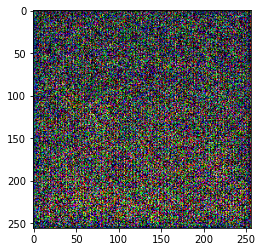

(4, 16, 16) (4, 16, 16)


In [ ]:
epochs = 100
loss=[]
for epoch in range(epochs):
    for u,o in zip(train_dataset_u, train_dataset_o):
        # loss.append(train_step((u,o)))
        print(1)
        train_step((u,o))
        
    break

In [ ]:
for u,o in zip(train_dataset_u, train_dataset_o):
  y,x=u,o
  break
with tf.GradientTape() as original1:
   gx = G(x, training=True)
   print(gx.shape)
   fgx = F(gx, training=True)
   print(fgx.shape)

   dxReal = Dx(x, training=True)
   print(dxReal[0].shape)
   dxFake = Dx(gx, training=True)
   print(dxFake[0].shape)

   lossDx = adverserial_loss(dxReal,dxFake) 
   lossGx = gen_loss(dxFake)

# gradsGx = original1.gradient(lossDx, G.trainable_weights)
gradsDx = original1.gradient(lossDx, Dx.trainable_weights)
plt.imshow(gx[0])
plt.show()
# print(gradsDx)
# print(lossDx, lossGx,'\n',np.array(G.trainable_weights).shape)
# G.optimizer.apply_gradients(zip(gradsGx,G.trainable_weights))
Dx.optimizer.apply_gradients(zip(gradsDx,Dx.trainable_weights))